In [453]:
import pickle
import pylab
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [454]:
'''
    数据读取
'''

target_dir = './vpm/result_taper_target/'
generate_dir = './vpm/result_taper_generate/'
target_results = []
generate_results = []

for file in os.listdir(target_dir):
    with open(os.path.join(target_dir,file),'rb') as filehandle:
        data = pickle.load(filehandle)
        target_results.append([data['time'][0], data['voltage'][0]])
        
for file in os.listdir(generate_dir):
    with open(os.path.join(generate_dir,file),'rb') as filehandle:
        data = pickle.load(filehandle)
        generate_results.append([data['time'][0], data['voltage'][0]])


In [455]:
'''
    均值方差计算
'''
target_result_mean = [np.mean([x[0] for x in target_results], axis=0), np.mean([np.mean(np.concatenate([arr.reshape(-1,1) for arr in x[1]], axis=1),1) for x in target_results],axis=0)]
target_result_std = [np.std([x[0] for x in target_results], axis=0), np.std([np.mean(np.concatenate([arr.reshape(-1,1) for arr in x[1]], axis=1),1) for x in target_results],axis=0)]
generate_result_mean = [np.mean([x[0] for x in generate_results], axis=0), np.mean([np.mean(np.concatenate([arr.reshape(-1,1) for arr in x[1]], axis=1),1) for x in generate_results],axis=0)]
generate_result_std = [np.std([x[0] for x in generate_results], axis=0), np.std([np.mean(np.concatenate([arr.reshape(-1,1) for arr in x[1]], axis=1),1) for x in generate_results],axis=0)]

In [456]:
'''
    指标计算
'''
import math
from scipy.signal import argrelextrema

def peaks(seq):
    peak_indices = argrelextrema(np.array(seq), np.greater)[0]
    # 去除峰值小的峰值
    peaks = []
    for peak_index in peak_indices:
        if seq[peak_index] > math.floor(np.max(seq)/ 10) * 10-10:
            peaks.append(peak_index)
    return peaks

def valleys(seq, peaks):
    # 寻找峰值对应的谷值
    valley_indices = argrelextrema(np.array(seq), np.less)[0]
    valley = []
    current_peak_idx = 0
    for valley_index in valley_indices:   
        assert current_peak_idx < len(peaks)  
        if valley_index > peaks[current_peak_idx]:
            valley.append(valley_index)
            current_peak_idx += 1
            if current_peak_idx >= len(peaks):
                break
    assert len(peaks) == len(valley)
    return valley

def begins(diff_seq, peaks):
    begin_indices = argrelextrema(-np.array(diff_seq), np.less)[0]
    begin = []
    current_peak_idx = len(peaks) - 1
    for begin_index in reversed(begin_indices):     
        if begin_index < peaks[current_peak_idx]:
            begin.append(begin_index)
            current_peak_idx -= 1
            if current_peak_idx < 0:
                break
    assert len(peaks) == len(begin)
    begin.reverse()
    return begin

def AP(seq, peaks, valley):
    # 计算AP
    aps = [seq[peaks[i]] - seq[valley[i]] for i in range(len(peaks))]
    return np.mean(aps)

def ISI(time, peaks):
    # 计算ISI
    fisi = time[peaks[1]] - time[peaks[0]]
    return fisi

def VB(time, seq):
    # 计算VB
    time_indices = np.where((np.array(time) >= 0) & (np.array(time) <= 500))
    return np.mean(seq[time_indices])
    # time_indices = np.argmin(time-500)
    # return seq[time_indices]

def AHP(seq, diff_seq, peak, valleys):
    # 寻找放电开始时刻
    begin_indices = begins(diff_seq, peak)
    # 计算AHP
    ahps = [seq[valleys[i]] - seq[begin_indices[i]+1] for i in range(len(valleys))]
    return begin_indices, np.mean(ahps)

def MF(time, seq, peaks, valley, begin):
    # 计算MF
    t = np.sum([time[valley[i]] - time[begin[i]] for i in range(len(peaks))])
    return t / len(peaks) 

def metric(time, seq, return_metric=True):
    diff_seq = np.diff(seq)
    peak_indices = peaks(seq)
    valley_indices = valleys(seq, peak_indices)

    
    ap = AP(seq, peak_indices, valley_indices)
    begin_indices, ahp = AHP(seq, diff_seq, peak_indices, valley_indices)
    mf = MF(time, seq, peak_indices, valley_indices, begin_indices)
    vb = VB(time, seq)
    isi = ISI(time, peak_indices)

    if return_metric:
        return [mf, ap, ahp, vb, isi]
    else:
        return diff_seq, peak_indices, valley_indices, begin_indices

In [457]:
target_metrics = [np.mean([metric(result[0], seq)for seq in result[1]],axis=0)for result in target_results]
generate_metrics = [np.mean([metric(result[0], seq)for seq in result[1]],axis=0)for result in generate_results]
target_metric = np.mean(target_metrics, axis=0)
generate_metric = np.mean(generate_metrics, axis=0)

np.set_printoptions(suppress=True)
print('Tareget:', np.round(target_metric,3))
print('Generate:', np.round(generate_metric,3))
print('Ratio:', np.round(abs(generate_metric-target_metric)/abs(target_metric),4))

Tareget: [ 17.634  43.021 -25.666 -84.242  38.004]
Generate: [ 15.381  44.382 -26.606 -85.031  45.068]
Ratio: [0.1278 0.0317 0.0366 0.0094 0.1859]


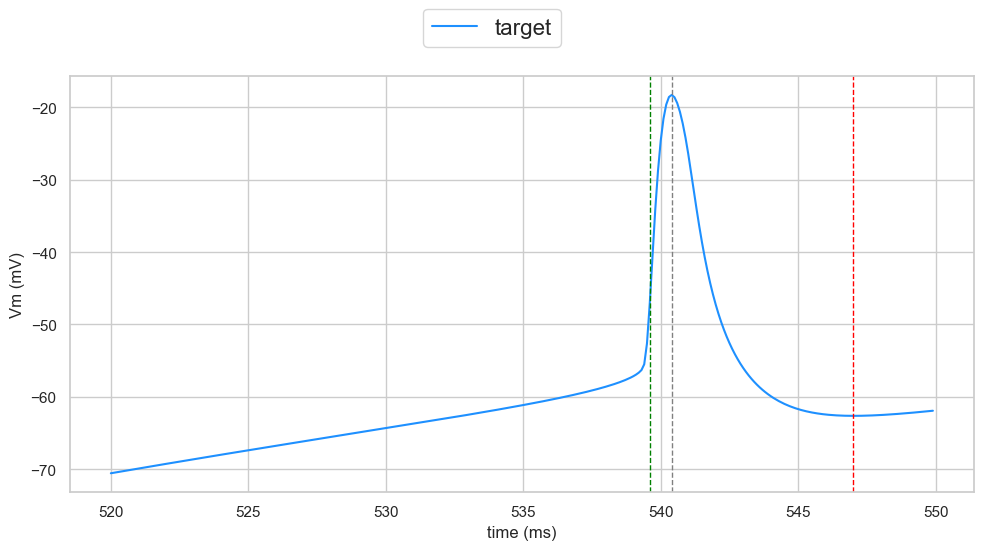

In [458]:
'''
    临时画图
'''

seq = target_results[0]
diff_seq, peak_indices, valley_indices, begin_indices = metric(seq[0], seq[1][0], False)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
sns.set(style='whitegrid')

ax.plot(seq[0][5200:5500], seq[1][0][5200:5500], c = 'dodgerblue', label='target')
# ax.plot(seq[0][:-1], diff_seq, c = 'dodgerblue', label='target')
ax.set_xlabel('time (ms)')
ax.set_ylabel('Vm (mV)')

for peak in peak_indices[0:1]:
    peak = seq[0][peak]
    plt.axvline(x=peak, color='gray', linestyle='--', linewidth=1)

for valley in valley_indices[0:1]:
    valley = seq[0][valley]
    plt.axvline(x=valley, color='red', linestyle='--', linewidth=1)

for begin in begin_indices[0:1]:
    begin = seq[0][begin]
    plt.axvline(x=begin, color='green', linestyle='--', linewidth=1)

fig.legend(loc='lower center', bbox_to_anchor=(0.5,1), fancybox=True, fontsize=16, ncol=9)
plt.tight_layout()
plt.show()

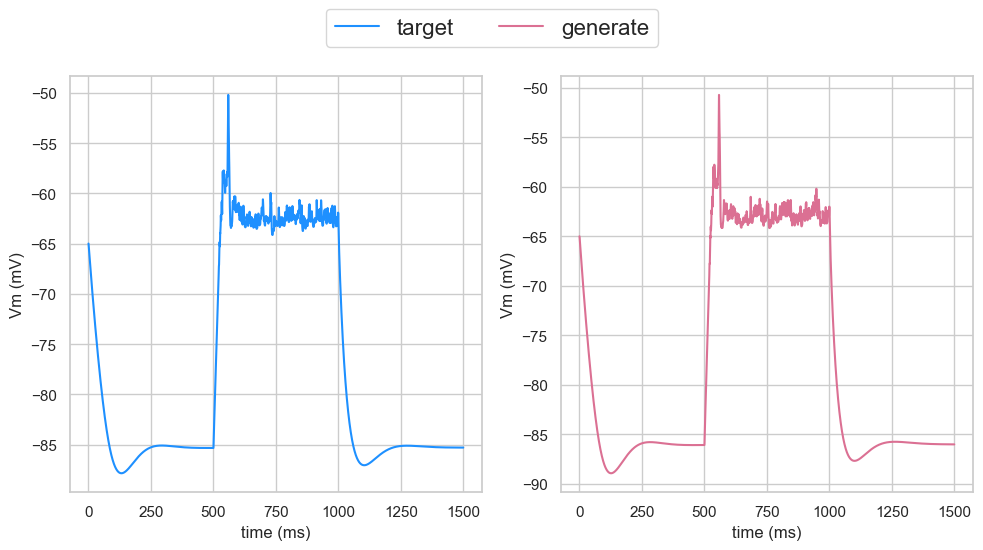

In [459]:
'''
    双子图画图
'''

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.set(style='whitegrid')

ax[0].plot(target_result_mean[0], target_result_mean[1], c = 'dodgerblue', label='target')
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('Vm (mV)')
# ax[0].set_title('Mean',size=22)

ax[1].plot(generate_result_mean[0], generate_result_mean[1], c = 'palevioletred', label='generate')
ax[1].set_xlabel('time (ms)')
ax[1].set_ylabel('Vm (mV)')

fig.legend(loc='lower center', bbox_to_anchor=(0.5,1), fancybox=True, fontsize=16, ncol=9)
plt.tight_layout()
plt.show()

In [460]:
'''
    平滑
'''
import statsmodels.api as sm

indices = np.where(target_result_mean[1]>-65)[0]
l = indices[0]
r = indices[-1]
frac = 0.01

from scipy.interpolate import UnivariateSpline

# # 样条插值
# spline = UnivariateSpline(target_result_mean[0][l:r], target_result_mean[1][l:r])
# spline.set_smoothing_factor(100)
# target_result_mean[1][l:r] = spline(target_result_mean[0][l:r])



# lowess = sm.nonparametric.lowess(target_result_mean[1][l:r], target_result_mean[0][l:r],frac=frac)
# target_result_mean[1][l:r] = lowess[:, 1]

# lowess = sm.nonparametric.lowess(generate_result_mean[1][l:r], generate_result_mean[0][l:r],frac=frac)
# generate_result_mean[1][l:r] = lowess[:, 1]

# lowess = sm.nonparametric.lowess(target_result_std[1][l:r], target_result_std[0][l:r],frac=frac)
# target_result_std[1][l:r] = lowess[:, 1]

# lowess = sm.nonparametric.lowess(generate_result_std[1][l:r], generate_result_std[0][l:r],frac=frac)
# generate_result_std[1][l:r] = lowess[:, 1]


/var/folders/yh/_xqq2_hx2yqfvgcmlycvmgg80000gn/T/ipykernel_37743/1367512880.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


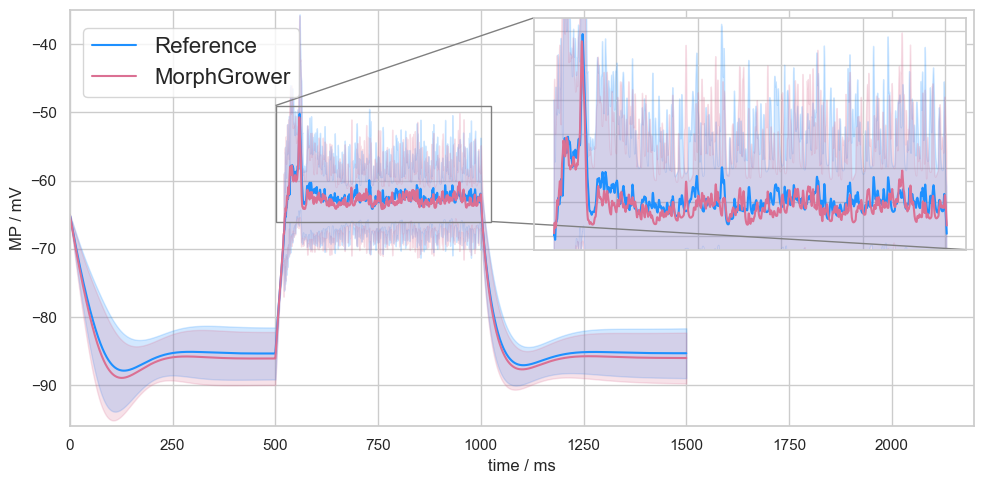

In [461]:
'''
    单子图画图
'''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
sns.set(style='whitegrid')

ax.plot(target_result_mean[0], target_result_mean[1], c = 'dodgerblue', label='Reference')
plt.fill_between(target_result_mean[0], target_result_mean[1]-target_result_std[1], target_result_mean[1]+target_result_std[1], color='dodgerblue', alpha=0.2)
ax.set_xlabel('time (ms)')
ax.set_ylabel('Vm (mV)')

ax.plot(generate_result_mean[0], generate_result_mean[1], c = 'palevioletred', label='MorphGrower')
plt.fill_between(generate_result_mean[0], generate_result_mean[1]-generate_result_std[1], generate_result_mean[1]+generate_result_std[1], color='palevioletred', alpha=0.2)
ax.set_xlabel('time / ms')
ax.set_ylabel('MP / mV')

ax.set_ylim((-96,-35))
ax.set_xlim((0,2200))

from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
axins = zoomed_inset_axes(ax, zoom=2, loc=1)

indices = np.where(target_result_mean[1]>-65)[0]
l = indices[0]
r = indices[-1]
axins.plot(target_result_mean[0][l:r], target_result_mean[1][l:r], c = 'dodgerblue')
plt.fill_between(target_result_mean[0][l:r], target_result_mean[1][l:r]-target_result_std[1][l:r], target_result_mean[1][l:r]+target_result_std[1][l:r], color='dodgerblue', alpha=0.2)
axins.plot(generate_result_mean[0][l:r], generate_result_mean[1][l:r], c = 'palevioletred')
plt.fill_between(generate_result_mean[0][l:r], generate_result_mean[1][l:r]-generate_result_std[1][l:r], generate_result_mean[1][l:r]+generate_result_std[1][l:r], color='palevioletred', alpha=0.2)
axins.tick_params(labelleft=False, labelbottom=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

axins.set_ylim((-66,-49))

fig.legend(loc='upper left', bbox_to_anchor=(0.08,0.95), fancybox=True, fontsize=16, ncol=1)
plt.tight_layout()
plt.show()

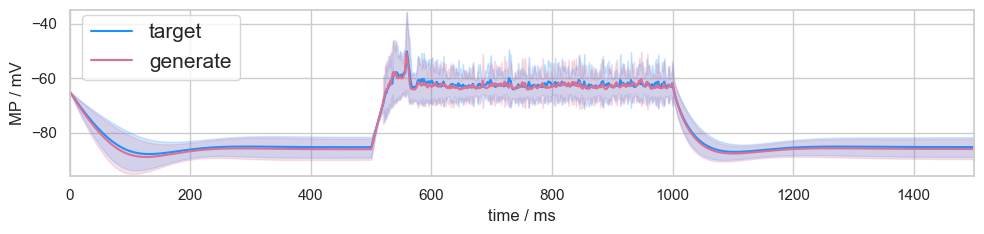

In [474]:
'''
    单子图画图
'''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,2.5))
sns.set(style='whitegrid')

ax.plot(target_result_mean[0], target_result_mean[1], c = 'dodgerblue', label='target')
plt.fill_between(target_result_mean[0], target_result_mean[1]-target_result_std[1], target_result_mean[1]+target_result_std[1], color='dodgerblue', alpha=0.2)
ax.set_xlabel('time / ms')
ax.set_ylabel('MP / mV')

ax.plot(generate_result_mean[0], generate_result_mean[1], c = 'palevioletred', label='generate')
plt.fill_between(generate_result_mean[0], generate_result_mean[1]-generate_result_std[1], generate_result_mean[1]+generate_result_std[1], color='palevioletred', alpha=0.2)

ax.set_ylim((-96,-35))
ax.set_xlim((0,1500))


fig.legend(loc='upper left', bbox_to_anchor=(0.08,0.95), fancybox=True, fontsize=15, ncol=1)
plt.tight_layout()
plt.savefig('intro_sp.pdf')